# PW1 - Handwritten character recognition


In [1]:
# Write your name here (e.g. "Edmond Dantès") so I can grade your work
your_name = "Meryem EL AISSAOUI"
assert your_name

In [2]:
%matplotlib inline
import math, sys, os, torch, torchvision
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


We will be training many models. Select a number of epochs to train each model. If you are using a slow machine, or if you want to restart training often and have many development iterations, we suggest `NUM_EPOCH = 2`. If you are using a fast machine, or have a GPU available, of if you are confident that you can write accurate code first try, you will get better accuracies by increasing this constant. You could be able to afford up to `NUM_EPOCH = 10`.

In [31]:
NUM_EPOCH = 2

# Part A - Linear, MLP, and CNN


## Handwritten digit recognition dataset

We will use the MNIST database (Modified National Institute of Standards and Technology database). It contains tens of thousands of pictures of handwritten digits. This database was compiled in 1994, as part of the effort in the 1990s to standardize automation of sorting devices with human input, for instance sorting mail with handwritten postal codes at the post office. This is now often considered one of the first real successes of neural networks, and the first easy example on which performance of new such algorithms is tested.

Load the dataset (train and test splits) using `torchvision`

In [92]:
root_dir = './data/MNIST/'

### YOUR CODE HERE ###

from torchvision import datasets, transforms

transform = transforms.ToTensor()

# Chargement des datasets
train_dataset = datasets.MNIST(root=root_dir, train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root=root_dir, train=False, transform=transform, download=True)

How many examples in each split? 

Plot the first image and label of the training set using `matplotlib`

What is the input dimension?

In [94]:
### YOUR CODE HERE ###
print(f"Nombre d'exemples dans l'entraînement : {len(train_dataset)}")
print(f"Nombre d'exemples dans le test : {len(test_dataset)}")

Nombre d'exemples dans l'entraînement : 60000
Nombre d'exemples dans le test : 10000


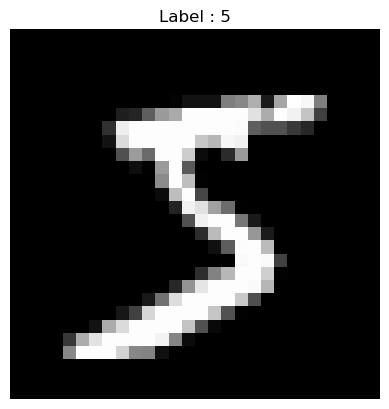

Dimensions de l'image : torch.Size([1, 28, 28])


In [95]:
### YOUR CODE HERE ###
image, label = train_dataset[0]

plt.imshow(image.squeeze(), cmap='gray')  
plt.title(f"Label : {label}")
plt.axis('off')
plt.show()

print(f"Dimensions de l'image : {image.shape}")



# A.1 - Linear features

We start with a very simple model, linear with respect to pixel values.
Use a `preprocess` function to downsample the image to 7x7 pixels, then flatten it and use a `torch.nn.Linear` model.

The torch average-pooling function is `torch.nn.functional.avg_pool2d`, check the documentation to set the arguments properly.
DO NOT use your implementation of average-pooling, it would take prohibitively long to train and you would not finish the practical.
If the training takes too long, go back to the first section and lower the `NUM_EPOCH` constant.

Again, use matplotlib to visualize an example of downsampling

In [96]:
### YOUR CODE HERE ###
import torch.nn.functional as F

def preprocess(x):
    return torch.nn.functional.avg_pool2d(x,kernel_size=4)

In [113]:
### YOUR ( MODEL / PREPROCESSING ) CODE HERE ###
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(7*7, 10)

    def forward(self, x):
        x = preprocess(x)
        x = x.view(x.size(0), -1) 
        return self.linear(x)



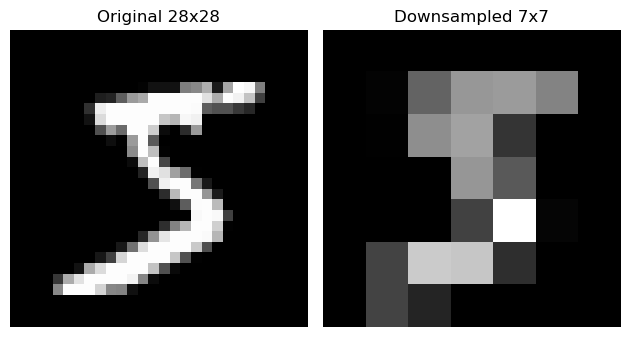

In [114]:
image, label = train_dataset[0]  

# Affichage original
plt.subplot(1, 2, 1)
plt.imshow(image.squeeze(), cmap='gray')
plt.title("Original 28x28")
plt.axis('off')

# Après downsampling avec preprocess()
image_down = preprocess(image)

plt.subplot(1, 2, 2)
plt.imshow(image_down.view(7, 7).detach(), cmap='gray')
plt.title("Downsampled 7x7")
plt.axis('off')

plt.tight_layout()
plt.show()


## A.2 - Loss and optimizer
Create a cross entropy loss.

In [115]:
### YOUR CODE HERE ###
model = LinearModel()

criterion = nn.CrossEntropyLoss()

## A.3 - Training and testing loops
Finally, create the functions `train(model, epoch, preprocess, optimizer)` and `test(model)` to train (one epoch with SGD and a learning rate of $10^{-3}$) and test your model.

In [116]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256)

In [117]:
def train(model, epoch, preprocess, optimizer):
    model.train()
    total, correct = 0, 0

    for batch in train_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    return optimizer, train_accuracy


def test(model, preprocess):
    model.eval()
    total, correct = 0, 0

    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


You should get at least 85\% test accuracy even with only 2 epochs. We will be aiming for around 95\% test accuracy and above.

In [118]:
model = LinearModel().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

for epoch in range(NUM_EPOCH):
    optimizer, train_acc = train(model, epoch, preprocess, optimizer)
    test_acc = test(model, preprocess)
    print(f"Epoch {epoch+1}/{NUM_EPOCH}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")


Epoch 1/2, Train Acc: 60.21%, Test Acc: 73.34%
Epoch 2/2, Train Acc: 74.72%, Test Acc: 78.13%


## A.4 - Multi-layer perceptron (MLP)

Create a class MLP that creates an MLP of given width and depth, and use it to create a 3-layer MLP of width $100$. We will assume that `width > 0` and `depth > 0`.

In [119]:
### YOUR CODE HERE ###

class MLP(nn.Module):
    def __init__(self, input_dim=784, width=100, depth=3, num_classes=10):
        super(MLP, self).__init__()

        layers = []
        layers.append(nn.Linear(input_dim, width))  # première couche

        for _ in range(depth - 1):  # couches cachées intermédiaires
            layers.append(nn.ReLU())
            layers.append(nn.Linear(width, width))

        layers.append(nn.ReLU())
        layers.append(nn.Linear(width, num_classes))  # sortie

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # aplatir
        return self.net(x)


In [121]:
model = MLP(input_dim=28*28, width=100, depth=3, num_classes=10).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

for epoch in range(NUM_EPOCH):
    optimizer, train_acc = train(model, epoch, lambda x: x, optimizer)
    test_acc = test(model, lambda x: x)
    print(f"Epoch {epoch+1}/{NUM_EPOCH}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")


Epoch 1/2, Train Acc: 55.26%, Test Acc: 82.10%
Epoch 2/2, Train Acc: 88.24%, Test Acc: 90.55%


# A.5 - Deep convolutional model

Write a convolutional model, with learned features.
Use two layers, one convolutional with 8 filters of size 3x3, then take a relu and max-pool with kernel size 2, and finally flatten and add a Linear layer. You can use the identity as pre-processing function.


Here is a little animation to remind you of the sliding window principle of convolutions.

![conv](https://github.com//vdumoulin/conv_arithmetic/raw/master/gif/no_padding_no_strides.gif)

In [122]:
### YOUR CODE HERE ###:
class ConvModel(nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc = nn.Linear(8 * 13 * 13, 10)  

    def forward(self, x):
        x = F.relu(self.conv(x))  
        x = self.pool(x)          
        x = x.view(x.size(0), -1) 
        x = self.fc(x)           
        return x


In [123]:
preprocess = lambda x: x

In [127]:
model = ConvModel().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
NUM_EPOCH = 2
for epoch in range(NUM_EPOCH):
    optimizer, train_acc = train(model, epoch, preprocess, optimizer)
    test_acc = test(model, preprocess)
    print(f"Epoch {epoch+1}/{NUM_EPOCH}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

Epoch 1/2, Train Acc: 83.25%, Test Acc: 90.86%
Epoch 2/2, Train Acc: 90.55%, Test Acc: 90.17%


In [126]:
model = ConvModel().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
NUM_EPOCH = 5
for epoch in range(NUM_EPOCH):
    optimizer, train_acc = train(model, epoch, preprocess, optimizer)
    test_acc = test(model, preprocess)
    print(f"Epoch {epoch+1}/{NUM_EPOCH}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")


Epoch 1/5, Train Acc: 83.22%, Test Acc: 89.42%
Epoch 2/5, Train Acc: 90.70%, Test Acc: 92.32%
Epoch 3/5, Train Acc: 92.28%, Test Acc: 93.22%
Epoch 4/5, Train Acc: 93.83%, Test Acc: 94.42%
Epoch 5/5, Train Acc: 94.64%, Test Acc: 94.80%


You should be able to get around 97\% to 98\% accuracy with this model. Try increasing the NUM_EPOCH constant and watch what happens to test accuracy and train accuracy as training progresses further.

Write a deeper convolutional model, with one convolutional layer as previously, but three linear layers with relu activations after that.
Use `h = 100` hidden neurons. How does the test accuracy compare with the previous two-layer network ?

In [129]:
class ConvDeepModel(nn.Module):
    def __init__(self, h=100):
        super(ConvDeepModel, self).__init__()

        # Convolution + MaxPool
        self.conv = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)

        # Dimension après pooling : (28 - 2)//2 = 13 → 8*13*13 = 1352
        self.fc1 = nn.Linear(8 * 13 * 13, h)
        self.fc2 = nn.Linear(h, h)
        self.fc3 = nn.Linear(h, 10)  # 10 classes

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 
        return x


In [130]:
preprocess = lambda x: x

In [ ]:
model = ConvDeepModel(h=100).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

NUM_EPOCH = 2
for epoch in range(NUM_EPOCH):
    optimizer, train_acc = train(model, epoch, preprocess, optimizer)
    test_acc = test(model, preprocess)
    print(f"Epoch {epoch+1}/{NUM_EPOCH}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")


Epoch 1/2, Train Acc: 72.58%, Test Acc: 90.80%
Epoch 2/2, Train Acc: 92.31%, Test Acc: 93.81%


In [132]:
NUM_EPOCH = 5
for epoch in range(NUM_EPOCH):
    optimizer, train_acc = train(model, epoch, preprocess, optimizer)
    test_acc = test(model, preprocess)
    print(f"Epoch {epoch+1}/{NUM_EPOCH}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

Epoch 1/5, Train Acc: 94.60%, Test Acc: 95.39%
Epoch 2/5, Train Acc: 95.64%, Test Acc: 95.87%
Epoch 3/5, Train Acc: 96.32%, Test Acc: 95.31%
Epoch 4/5, Train Acc: 96.83%, Test Acc: 96.47%
Epoch 5/5, Train Acc: 97.18%, Test Acc: 96.03%


## A.6 Visualisations of convolutions

After training your model, let's see what features it has learned!

Plot an image from the test set then plot all 8 feature maps extracted by the convolutional layer

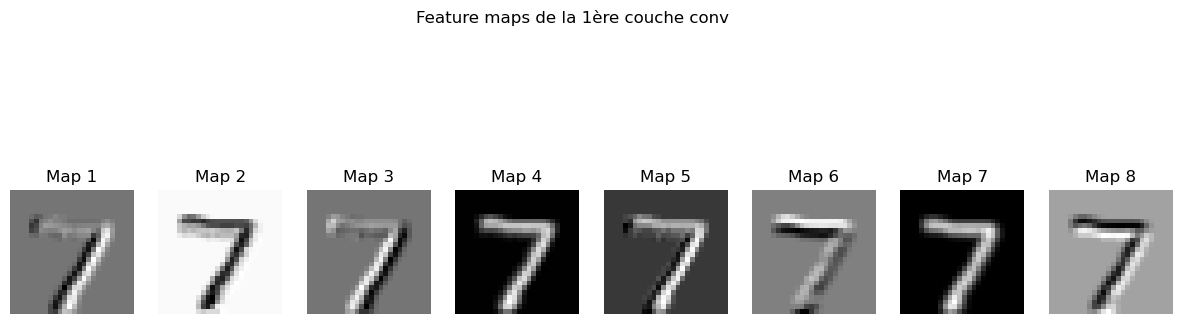

In [ ]:
images, labels = next(iter(test_loader))
img = images[0].unsqueeze(0).to(device)  


with torch.no_grad():
    conv_output = model.conv(img)  

fig, axes = plt.subplots(1, 8, figsize=(15, 5))
for i in range(8):
    axes[i].imshow(conv_output[0, i].cpu(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Map {i+1}")
plt.suptitle("Feature maps de la 1ère couche conv")
plt.show()


# Part B - Residual models

## B.1 - Residual blocks

Write a residual block with two linear layers to learn a function $\mathbb{R}^d \to \mathbb{R}^d$ with $h < d$ hidden neurons.
Write a convolutional residual block with the same idea. What hyperparameter acts as the number of hidden neurons in convolutional blocks ?

In [ ]:

class ResidualBlock(nn.Module):
    def __init__(self, d, h):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(d, h)
        self.fc2 = nn.Linear(h, d)

    def forward(self, x):
        out = F.relu(self.fc1(x))  
        out = self.fc2(out)        
        return x + out             
# l'hyperparametre qui joue le role du nombre de couches cachés est  nombre de filtres 

## B.2 - Stacking residual blocks

Use a single convolution layer, followed by a relu and max-pool, then an arbitrary number of residual blocks as defined above, and finish with a linear layer. Can you match the accuracy of the two-layer network ? Can you exceed it ? What happens when you increase the number of layers ? Look at the details of the ResNet architecture on the lecture's slides to get an idea of how to increase the number of hidden neurons and the number of layers. One of the strengths of ResNets was there relatively low number of parameters compared
to a multi-layer architecture like that of the previous section, does this show in your experiments ?

In [ ]:
class ResidualModel(torch.nn.Module):
    def __init__(self, l, h, k=3, out=8):
        super(ResidualModel, self).__init__()
        ### YOUR CODE HERE ###

    def forward(self,x):
        ### YOUR CODE HERE ###
        pass

# Part C - Reimplementing loss functions

## C.0 - Combining losses
First, we recall that, for a batch of score vectors $s\in\mathbb{R}^{n\times C}$ and true labels $y\in[1,C]^n$, **cross entropy** is defined as
$$CE(s, y) = -\frac{1}{n}\sum_{i=1}^n \log\left( \mbox{softmax}(s_i)_{y_i} \right)$$

where $\mbox{softmax}(x)_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$ is the probability associated to class $i\in[1,C]$ for a score vector $x\in\mathbb{R}^C$.

Let's try to compute cross-entropy in three different ways (see the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)):
1. Using `nn.CrossEntropyLoss()`.
2. Using `nn.NLLLoss()` and `nn.LogSoftmax()`.
3. Using `nn.NLLLoss()` and `nn.Softmax()`.

Check that the output is the same for all three methods on Gaussian random scores `torch.randn(n_batch, n_classes)` and random labels `torch.randint(0, n_classes, [n_batch])`, where `n_batch=4` and `n_classes=10`. Note that the scores are real valued vectors while the labels are integers corresponding to the true class.

In [24]:
### YOUR CODE HERE ###

## C.1 - Re-implementation
Now re-implement cross-entropy using base functions (`torch.log`, `torch.exp`, `torch.sum`, etc...). Verify that your function returns the same value as Pytorch's implementation.

In [25]:
def ce(logits, targets):
    ### YOUR CODE HERE ###
    pass

## C.2 - Stability analysis
Softmax probabilities can be relatively unstable due to their use of exponentials. Pytorch implementations thus usually use log probas or logits to avoid overflows or floating point errors. Test all methods (including your own) on Gaussian random scores of standard deviation equal to $100$. Which methods are stable? Why? Is it an issue in practice?

In [26]:
### YOUR CODE HERE ###

Re-implement a stable version of cross-entropy.

In [27]:
def stable_ce(logits, targets):
    ### YOUR CODE HERE ###
    pass